In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [2]:
## import helper functions

import sys
sys.path.append("../")
from src.clean_churn_data import clean_churn_data
from src.roc import plot_roc_curve
from src.confusion_df import confusion_df
from src.confusion_df import render_mpl_table
%load_ext autoreload
%autoreload 2

In [1]:
## import sklearn modules

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
# import tensorflow modules. tensorflow was run on a docker container

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import Precision, Recall

In [3]:
# load and clean data

churn = pd.read_csv('../data/churn_train.csv')
churn = clean_churn_data(churn)
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39681 entries, 0 to 39999
Data columns (total 13 columns):
avg_dist                  39681 non-null float64
avg_rating_by_driver      39681 non-null float64
avg_rating_of_driver      39681 non-null float64
avg_surge                 39681 non-null float64
phone                     39681 non-null int64
surge_pct                 39681 non-null float64
trips_in_first_30_days    39681 non-null int64
luxury_car_user           39681 non-null int64
weekday_pct               39681 non-null float64
city: Astapor             39681 non-null int64
city: King's Landing      39681 non-null int64
city: Winterfell          39681 non-null int64
churn?                    39681 non-null int64
dtypes: float64(6), int64(7)
memory usage: 4.2 MB


In [38]:
# feature engineering

cols = ['avg_dist','avg_rating_by_driver','avg_rating_of_driver','avg_surge','surge_pct','trips_in_first_30_days','weekday_pct']

for col in cols:
    churn[(col + ' x^2')] = churn[col] ** 2
    churn[(col + ' x^3')] = churn[col] ** 3
    churn[(col + ' exp^x')] = np.exp(churn[col])
    churn[(col + ' log')] = np.log(churn[col] + 10**-10)
    churn[(col + ' sin')] = np.sin(churn[col])
    churn[(col + ' cos')] = np.cos(churn[col])
    churn[(col + ' 1/x')] = 1 / (churn[col] + 10**-10)
    
    for col2 in cols:
        churn[(col + ' * ' + col2)] = churn[col] * churn[col2]

In [42]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39681 entries, 0 to 39999
Columns: 111 entries, avg_dist to weekday_pct log
dtypes: float64(101), int64(10)
memory usage: 33.9 MB


In [43]:
# create model data

X = churn.drop(columns=['churn?']).values
y = churn['churn?'].values
X[X > 10**10] = 10**10   # reset inf values

In [44]:
# split data

X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(29760, 110) (9921, 110) (29760,) (9921,)


In [45]:
# standardize data

scaler_train = StandardScaler()
X_train = scaler_train.fit_transform(X_train)

In [46]:
# create and compile neural network

n_samples, n_feats = X_train.shape

model = Sequential()

hidden_units = n_feats
n_classes = 1
epochs = 1000
sgd_lr = 0.01

hidden_layer = Dense(units=hidden_units,
                input_dim=n_feats,
                kernel_initializer='uniform',
                activation='relu')

hidden_layer2 = Dense(units=hidden_units,
                input_dim=n_feats,
                kernel_initializer='uniform',
                activation='tanh')

output_layer = Dense(units=n_classes,
                input_dim=hidden_units,
                kernel_initializer='uniform',
                activation='sigmoid')

model.add(hidden_layer)
model.add(hidden_layer2)
model.add(output_layer)
model.add(Dropout(rate=0.5))

opt = SGD(lr=sgd_lr)
model.compile(loss='binary_crossentropy', 
              optimizer=opt, 
              metrics=["accuracy", Precision(), Recall()] )

history = model.fit(X_train, y_train, 
          epochs=epochs, 
          batch_size=5000, 
          verbose=2, 
          validation_split=0.2)

Train on 23808 samples, validate on 5952 samples
Epoch 1/1000
23808/23808 - 1s - loss: 5.6054 - accuracy: 0.3986 - precision: 0.6155 - recall: 0.1039 - val_loss: 1.5523 - val_accuracy: 0.3711 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/1000
23808/23808 - 0s - loss: 5.3897 - accuracy: 0.3742 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.5319 - val_accuracy: 0.3711 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/1000
23808/23808 - 0s - loss: 5.4089 - accuracy: 0.3742 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.5124 - val_accuracy: 0.3711 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/1000
23808/23808 - 0s - loss: 5.3398 - accuracy: 0.3742 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4933 - val_accuracy: 0.3711 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/1000
23808/23808 - 0s - loss: 5.4254 - accuracy: 0.3742 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4755 - val_accuracy:

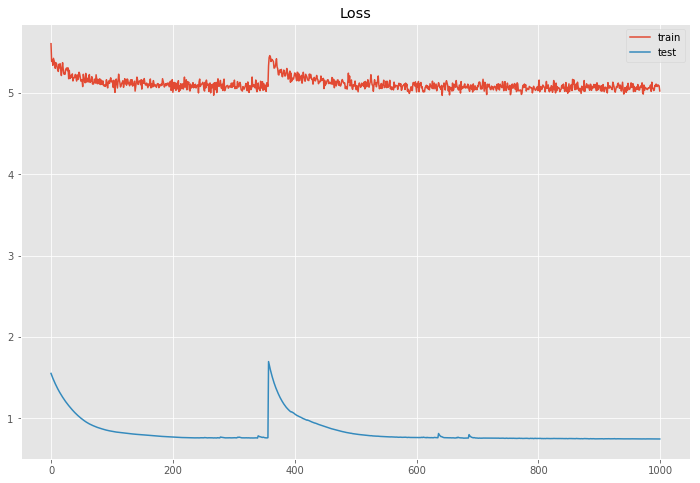

In [47]:
# figure of loss over time

fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Loss')
ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='test')
ax.legend();

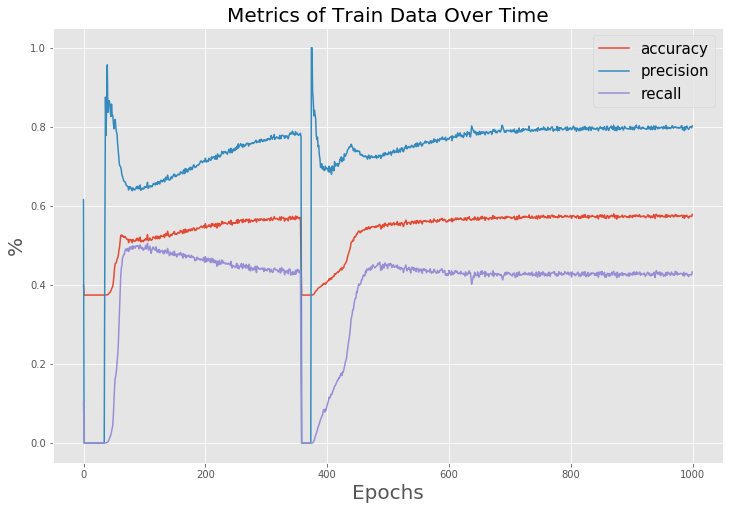

In [49]:
# figure of metrics over time

fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Metrics of Train Data Over Time', fontsize=20)
ax.plot(history.history['accuracy'], label='accuracy')
ax.plot(history.history['precision'], label='precision')
ax.plot(history.history['recall'], label='recall')
ax.set_xlabel('Epochs', fontsize=20)
ax.set_ylabel('%', fontsize=20)
ax.legend(loc='best', fontsize=15);
fig.savefig('../img/metrics_nn.png', bbox_inches='tight')

In [50]:
# scale test data and generate predictions

scaler_test = StandardScaler()
X_test = scaler_train.fit_transform(X_test)
y_hat = model.predict(X_test)

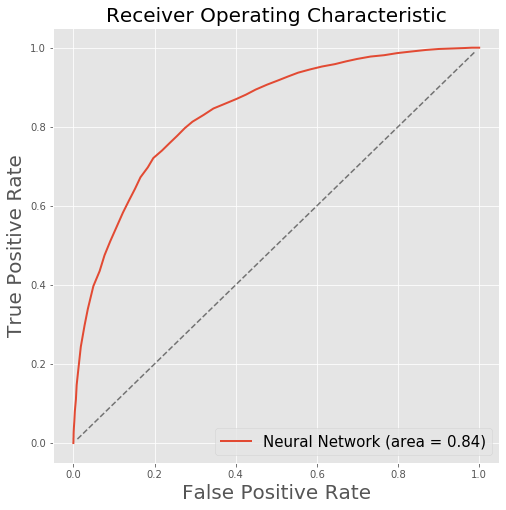

In [6]:
# plot ROC

fig, ax = plt.subplots(figsize=(8,8))

ax, tpr, fpr, thresholds = plot_roc_curve(y_hat, y_test, ax, title='Neural Network')

fig.savefig('../img/roc_nn.png', bbox_inches='tight')

In [52]:
# save prediction data to txt for later ROC overlay

np.savetxt('../data/nn_y_hat.txt', y_hat)
np.savetxt('../data/nn_y_test.txt', y_test)

In [3]:
y_hat = np.loadtxt('../data/nn_y_hat.txt')
y_test = np.loadtxt('../data/nn_y_test.txt')

In [4]:
cm_df = confusion_df(y_test, (y_hat > 0.5).astype(int))
cm_df

,Predicted Negative,Predicted Positive
Actual Negative,3805,11
Actual Positive,5710,395


<ipython-input-5-f9775680bad9>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


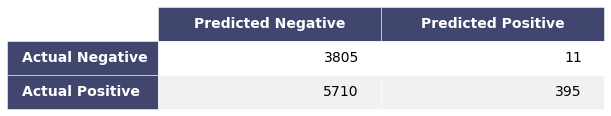

In [5]:
fig, ax = render_mpl_table(cm_df)
fig.show()
fig.savefig('../img/nn_conf_mat.png', bbox_inches='tight')